<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Quantum Counterfeit Coin Problem*_ 
For more information about how to use the IBM Q experience (QX), consult the [tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Rudy Raymond, Takashi Imamichi

## Introduction

The counterfeit coin problem is a classic puzzle first proposed by E. D. Schell in the January 1945 edition of the American Mathematical Monthly:

>You have eight similar coins and a beam balance. At most one coin is counterfeit and hence underweight. How can you detect whether there is an underweight coin, and if so, which one, using the balance only twice?

The anwer to the above puzzle is affirmative. What happens when we can use a quantum beam balance? 

Given a quantum beam balance and a counterfeit coin among $N$ coins, there is a quantum algorithm that can find the counterfeit coin by using the quantum balance only once (and independent of $N$, the number of coins!). On the other hand any classical algorithm requires at least $\Omega(\log{N})$ usage of the beam balance. In general, for a given $k$ counterfeit coin problems of the same weight (but different from the majority of normal coins), there is [a quantum algorithm](https://arxiv.org/pdf/1009.0416.pdf) that queries the quantum beam balance for $O(k^{1/4})$ in contrast to any classical algorithm that requires $\Omega(k\log{(N/k)})$ queries to the beam balance. This is one of the wonders of quantum algorithms in terms of query complexity that achieves quartic speed-up than its classical counterpart.

## Quantum Procedure
Hereafter we describe a step-by-step procedure to program the Quantum Counterfeit Coin Problem for $k=1$ counterfeit coin with the IBM Q Experience. [Terhal and Smolin](https://arxiv.org/pdf/quant-ph/9705041.pdf) were the first to show that it is possible to identify the false coin with a single query to the quantum beam balance.  

### Preparing the environment
First, we prepare the environment. 

In [1]:
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")

# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# useful math functions
from math import pi, cos, acos, sqrt

sys.path.append("../../")
# importing the QISKit
from qiskit import QuantumProgram
import Qconfig

# import basic plot tools
from qiskit.basicplotter import plot_histogram

### Setting the number of coins and the index of false coin

Next, we set the number of coins and the index of the counterfeit coin. The former determines the quantum superpositions used by the algorithm, while the latter determines the quantum beam balance.

In [2]:
M = 16                   #Maximum number of physical qubits available
numberOfCoins = 8        #This number should be up to M-1, where M is the number of qubits available
indexOfFalseCoin = 5     #This should be 0, 1, ..., numberOfCoins - 1, where we use python indexing

if numberOfCoins < 4 or numberOfCoins >= M:
    raise Exception("Please use numberOfCoins between 4 and ", M-1)
if indexOfFalseCoin < 0 or indexOfFalseCoin >= numberOfCoins:
    raise Exception("indexOfFalseCoin must be between 0 and ", numberOfCoins-1)

### Querying the quantum beam balance

As in a classical algorithm to find the false coin, we will use the balance by placing the same amount of coins on the left and right pans of the beam. The difference is that in a quantum algorithm we can query the beam balance in superposition. To query the quantum beam balance, we use a binary query string to encode coins placed on the pans. Namely, the binary string `01101010` means to place coins whose indices are 1, 2, 4, and 6 to the pans. While the binary string `01110111` means to place all coins but those with indices 0 and 4 on the pans. Notice that we do not care how the selected coins are placed on the left and right pans, because their results are the same: it is balanced when no false coin is included, and tilted otherwise. 

In our example, because the number of coins is $8$ and the index of false coin is $3$, the query `01101010` will result in balanced (or, $0$), while the query `01110111` will result in tilted (or, $1$). Using two quantum registers to query the quantum balance, where the first register is for the query string and the second register for the result of the quantum balance, we can write the query to the quantum balance (omitting the normalization of the amplitudes): 

\begin{eqnarray}
|01101010\rangle\Big( |0\rangle - |1\rangle \Big) &\xrightarrow{\mbox{Quantum Beam Balance}}& |01101010\rangle\Big( |0\oplus 0\rangle - |1 \oplus 0\rangle \Big) = |01101010\rangle\Big( |0\rangle - |1\rangle \Big)\\
|01110111\rangle\Big( |0\rangle - |1\rangle \Big) &\xrightarrow{\mbox{Quantum Beam Balance}}& |01110111\rangle\Big( |0 \oplus 1\rangle - |1 \oplus 1\rangle \Big) = (-1) |01110111\rangle\Big( |0 \rangle - |1 \rangle \Big)
\end{eqnarray}

Notice that in the above equation, the phase is flipped if and only if the binary query string is $1$ at the index of the false coin. Let $x \in \left\{0,1\right\}^N$ be the $N$-bit query string (that contains even number of $1$'s), and let $e_k \in \left\{0,1\right\}^N$ be the binary string which is $1$ at the index of the false coin and $0$ otherwise. Clearly, 

$$
|x\rangle\Big(|0\rangle - |1\rangle \Big) \xrightarrow{\mbox{Quantum Beam Balance}} \left(-1\right) ^{x\cdot e_k} |x\rangle\Big(|0\rangle - |1\rangle \Big), 
$$
where $x\cdot e_k$ denotes the inner product of $x$ and $e_k$. 

Here, we will prepare the superposition of all binary query strings with even number of $1$'s. Namely, we want a circuit that produces the following transformation:

$$
|0\rangle \rightarrow \frac{1}{2^{(N-1)/2}}\sum_{x\in \left\{0,1\right\}^N~\mbox{and}~|x|\equiv 0 \mod 2} |x\rangle,
$$

where $|x|$ denotes the Hamming weight of $x$.

To obtain such superposition of states of even number of $1$'s, we can perform Hadamard transformation on $|0\rangle$ to obtain superposition of $\sum_{x\in\left\{0,1\right\}^N} |x\rangle$, and check if the Hamming weight of $x$ is even. It can be shown that the Hamming weight of $x$ is even if and only if $x_1 \oplus x_2 \oplus \ldots \oplus x_N = 0$. Thus, we can transform:

\begin{equation}
|0\rangle|0\rangle \xrightarrow{H^{\oplus N}} \frac{1}{2^{N/2}}\sum_x |x\rangle |0\rangle \xrightarrow{\mbox{XOR}(x)} \frac{1}{2^{N/2}}\sum_x |x\rangle |0\oplus x_1 \oplus x_2 \oplus \ldots \oplus x_N\rangle 
\end{equation}

The right-hand-side of the equation can be divided based on the result of the $\mbox{XOR}(x) = x_1 \oplus \ldots \oplus x_N$, namely, 

$$
\frac{1}{2^{(N-1)/2}}\sum_{x\in \left\{0,1\right\}^N~\mbox{and}~|x|\equiv 0 \mod 2} |x\rangle|0\rangle + \frac{1}{2^{(N-1)/2}}\sum_{x\in \left\{0,1\right\}^N~\mbox{and}~|x|\equiv 1 \mod 2} |x\rangle|1\rangle.
$$

Thus, if we perform measurement on the second register and observe $|0\rangle$, the first register is the superposition of all binary query strings we want. If we fail (observe $|1\rangle$), we repeat the above procedure until we observe $|0\rangle$. Each repetion is guaranteed to succeed with probability exactly half. Hence, after several repetitions we should be able to obtain the desired superposition state. *Notice that we can perform [quantum amplitude amplification](https://arxiv.org/abs/quant-ph/0005055) to obtain the desired superposition states with certainty and without measurement. The detail is left as an exercise*.

Below is the procedure to obtain the desired superposition state with the classical `if` of the QuantumProgram. Here, when the second register is zero, we prepare it to record the answer to quantum beam balance. 

In [3]:
Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url

# Creating registers
# numberOfCoins qubits for the binary query string and 1 qubit for working and recording the result of quantum balance
qr = Q_program.create_quantum_register("qr", numberOfCoins+1)
# for recording the measurement on qr
cr = Q_program.create_classical_register("cr", numberOfCoins+1)

circuitName = "QueryStateCircuit"
queryStateCircuit = Q_program.create_circuit(circuitName, [qr], [cr])

N = numberOfCoins
#Create uniform superposition of all strings of length N
for i in range(N):
    queryStateCircuit.h(qr[i])

#Perform XOR(x) by applying CNOT gates sequentially from qr[0] to qr[N-1] and storing the result to qr[N]
for i in range(N):
    queryStateCircuit.cx(qr[i], qr[N])

#Measure qr[N] and store the result to cr[N]. We continue if cr[N] is zero, or repeat otherwise
queryStateCircuit.measure(qr[N], cr[N])

#we proceed to query the quantum beam balance if the value of cr[0]...cr[N] is all zero
#by preparing the Hadamard state of |1>, i.e., |0> - |1> at qr[N]
queryStateCircuit.x(qr[N]).c_if(cr, 0)
queryStateCircuit.h(qr[N]).c_if(cr, 0)

#we rewind the computation when cr[N] is not zero
for i in range(N):
    queryStateCircuit.h(qr[i]).c_if(cr, 2**N)


### Constructing the quantum beam balance

The quantum beam balance returns $1$ when the binary query string contains the position of the false coin and $0$ otherwise, provided that the Hamming weight of the binary query string is even. Notice that previously, we have constructed the superposition of all binary query strings whose Hamming weights are even. Let $k$ be the position of the false coin, then with regards to the binary query string $|x_1,x_2,\ldots,x_N\rangle|0\rangle$, the quantum beam balance simply returns $|x_1,x_2,\ldots,x_N\rangle|0\oplus x_k\rangle$, that can be realized by a CNOT gate with $x_k$ as control and the second register as target. Namely, the quantum beam balance realizes

$$
|x_1,x_2,\ldots,x_N\rangle\Big(|0\rangle - |1\rangle\Big) \xrightarrow{\mbox{Quantum Beam Balance}} |x_1,x_2,\ldots,x_N\rangle\Big(|0\oplus x_k\rangle - |1 \oplus x_k\rangle\Big) = \left(-1\right)^{x\cdot e_k} |x_1,x_2,\ldots,x_N\rangle\Big(|0\rangle - |1\rangle\Big)
$$

Below we apply the quantum beam balance on the desired superposition state. 

In [4]:
k = indexOfFalseCoin
#Apply the quantum beam balance on the desired superposition state (marked by cr equal to zero)
queryStateCircuit.cx(qr[k], qr[N]).c_if(cr, 0)

### Identifying the false coin

In the above, we have queried the quantum beam balance once. How to identify the false coin after querying the balance? We simply perform Hadamard transformation on the binary query string to identify the false coin. Notice that under the assumption that we query the quantum beam balance with binary strings of even Hamming weight, the following equations hold.

\begin{eqnarray}
\frac{1}{2^{(N-1)/2}}\sum_{x\in \left\{0,1\right\}^N~\mbox{and}~|x|\equiv 0 \mod 2} |x\rangle &\xrightarrow{\mbox{Quantum Beam Balance}}& \frac{1}{2^{(N-1)/2}}\sum_{x\in \left\{0,1\right\}^N~\mbox{and}~|x|\equiv 0 \mod 2} \left(-1\right)^{x\cdot e_k} |x\rangle\\
\frac{1}{2^{(N-1)/2}}\sum_{x\in \left\{0,1\right\}^N~\mbox{and}~|x|\equiv 0 \mod 2} \left(-1\right)^{x\cdot e_k} |x\rangle&\xrightarrow{H^{\otimes N}}&  \frac{1}{\sqrt{2}}\Big(|e_k\rangle+|\hat{e_k}\rangle\Big)
\end{eqnarray}

In the above $e_k$ is the bit string that is $1$ only at the position of the false coin, and $\hat{e_k}$ is its inverse. Thus, by performing the measurement in the computational basis after the Hadamard transform, we should be able to identify the false coin because it is the one whose label is different from the majority: when $e_k$, the false coin is labelled $1$, and when $\hat{e_k}$ the false coin is labelled $0$. 

In [5]:
#Apply Hadamard transform on qr[0] ... qr[N-1]
for i in range(N):
    queryStateCircuit.h(qr[i]).c_if(cr, 0)

#Measure qr[0] ... qr[N-1]
#queryStateCircuit.measure(qr, cr) #THIS IS NOT SUPPORTED? 
for i in range(N):
    queryStateCircuit.measure(qr[i], cr[i])

Now, we perform experiment to see how we can identify the false coin by the above quantum circuit. Notice that when we use the `plot_histogram`, the numbering of the bits in the classical register is from right to left, namely, `0100` means the bit with index $2$ is one and the rest are zero. 

Because we use `cr[N]` to control the operation prior-to and after the query to the quantum beam balance, we can detect that we succeed in identifying the false coin when the left-most bit is $0$. Otherwise, when the left-most bit is $1$, we fail to obtain the desired superposition of query bitstrings and must repeat from the beginning. *Notice that we have not queried the quantum beam oracle yet. This repetition is not neccesary when we feed the quantum beam balance with the superposition of all bistrings of even Hamming weight, which can be done with probabiltiy one thanks to the quantum amplitude amplification*. 

When the left-most bit is $0$, the index of the false coin can be determined by finding the one whose values are different from others. Namely, when $N=8$ and the index of the false coin is $3$, we should observe `011110111` or `000001000`.

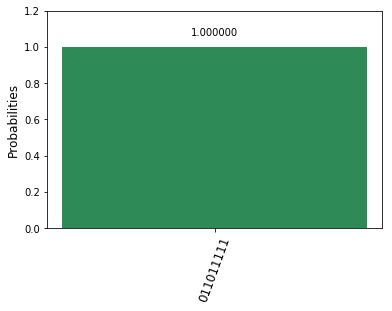

False coin index is:  5


In [9]:
backend = "local_qasm_simulator"
#backend = "ibmqx3"
shots = 1 # We perform a one-shot experiment
Q_program.execute([circuitName], backend=backend, shots=shots)
answer = Q_program.get_counts(circuitName)
for key in answer.keys():
    if key[0:1] == "1":
        raise Exception("Fail to create desired superposition of balanced query string. Please try again")
        
plot_histogram(answer)
from collections import Counter
for key in answer.keys():
    normalFlag, _ = Counter(key[1:]).most_common(1)[0] #get most common label
    for i in range(2,len(key)):
        if key[i] != normalFlag:
            print("False coin index is: ", len(key) - i - 1)

## About Quantum Counterfeit Coin Problem

The case when there is a single false coin, as presented in this notebook, is essentially [the Bernstein-Vazirani algorithm](http://epubs.siam.org/doi/abs/10.1137/S0097539796300921), and the single-query coin-weighing algorithm was first presented in 1997 by [Terhal and Smolin](https://arxiv.org/pdf/quant-ph/9705041.pdf). The Quantum Counterfeit Coin Problem for $k > 1$ in general is studied by [Iwama et al.](https://arxiv.org/pdf/1009.0416.pdf). It is still open if there exists a quantum algorithm that only needs $o(k^{1/4})$ queries to identify all the false coins. 